In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session





In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras

In [ ]:
exoTest = pd.read_csv('../input/kepler-labelled-time-series-data/exoTest.csv')
exoTrain = pd.read_csv('../input/kepler-labelled-time-series-data/exoTrain.csv')

# windelta's Acknowledgements
The data presented here are cleaned and are derived from observations made by the NASA Kepler space telescope  
Over 99% of this dataset originates from Campaign 3  
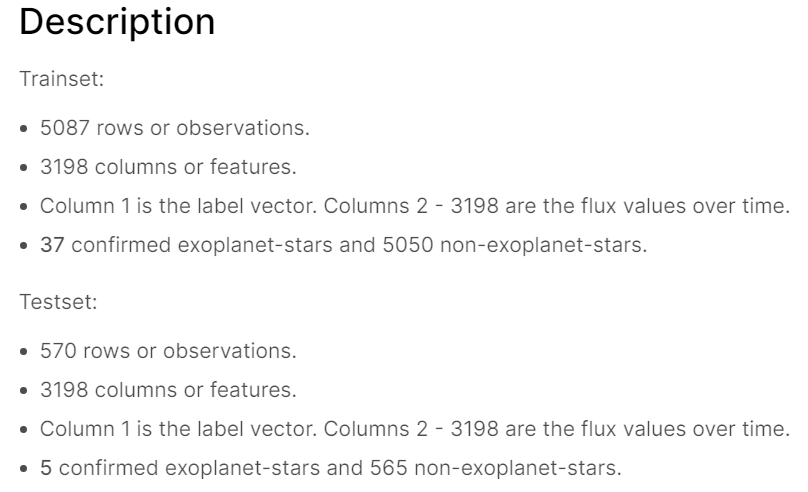  
Using Kepler Space Telescope Data to Identify an Exoplanet  
: https://www.sciencebuddies.org/science-fair-projects/project-ideas/Exoplanets_p002/exoplanets/kepler-data-exoplanet  
Campain Fields: https://archive.stsci.edu/missions-and-data/k2/campaign-fields.html#c3  


In [ ]:
'''
data Description
rows: a star data
columns:
    LABEL -> 2 is an exoplanet star and 1 is a non-exoplanet-star.
    FLUX.1-FLUX.3197 -> the light intensity recorded for each star, at a different point in time.
'''
print(exoTrain.dtypes)
print(exoTrain.info())
print(exoTrain.head())

In [ ]:
exoTrain['LABEL'].value_counts(), exoTest['LABEL'].value_counts()

In [ ]:
mask_exo = exoTrain['LABEL'] == 2
mask_non = exoTrain['LABEL'] == 1

exo = exoTrain[mask_exo]
nonExo = exoTrain[mask_non]

## Helper Function

In [120]:
# Preprocessing DataFrame data
def preDF(df_: pd.DataFrame):
    # Numerical data로 plotting 하기 위한 전처리
    '''
    Input Description
        dtype: pd.DataFrame
        df_.index: [0, ...] -> meaning stars
        df_.columns: [LABEL, FLUX.1, ..., FLUX.3197]
        
        FLUX 뒤의 숫자 1~3197이 시간인 것을 감안하였을 때, 
        이를 시계열 데이터로 변환하기 위해서는 Transpose가 요구됨
    '''
    df = df_
    
    # discard the LABEL column
    df = df.loc[:, df.columns != 'LABEL']
    
    df.index.name = 'stars'
    idx_list = df.index
    
    # converting 1-3197 integer value to datetime
    # startTime, endTime are on the 'Campagin Field by Mikulski Archive'
    startTime = '2014-11-14'
    endTime = '2015-02-03'
    col_list = pd.date_range(startTime, endTime, periods = len(df.columns), 
                             name = 'datetime')
    
    # Need to normalize
    # StandardScaler는 이상값에 영향을 많이 받음
    # 값이 이상하다면 RobustScaler 사용
    df = df.T
    scaler = RobustScaler()
    scaler.fit(df)
    numpy_scaled = scaler.transform(df)
    print(numpy_scaled)
    df_scaled = pd.DataFrame(numpy_scaled, 
                             index=col_list, columns=idx_list)
    
    df_scaled = df_scaled.T
    return df_scaled

# plotting function with preprocessed data
def plotDF(df_: pd.DataFrame):
    '''
    Input Description:
        df_.index: stars
        df_.columns: datetime
        values: FLUX
    '''
    df_scaled = preDF(df_).T
    
    # plotting
    plt.plot(df_scaled.loc[df_scaled.index != 'LABEL', :])
    plt.title('Normalized FLUX following the time')
    plt.legend(df_scaled.columns, 
               title = 'star number(exoplanet around star)', 
               bbox_to_anchor=(1, 1))
    plt.xlabel('time interval')
    plt.ylabel('Normalized FLUX(=light intensity)')
    plt.show()

In [121]:
plotDF(exo.iloc[:2]), plotDF(nonExo.iloc[:2])

In [ ]:
df = pd.concat([exo.iloc[:2], nonExo.iloc[:2]], axis=0)
plotDF(df)

## Singlevariate(=FLUX) time series forecasting

In [ ]:
exoTrain.head()

In [ ]:
startTime = '2014-11-14'
endTime = '2015-02-03'
df = exoTrain

col_list

In [ ]:
train_X = preDF(exoTrain)
train_y = exoTrain['LABEL']
test_X = preDF(exoTest)
test_y = exoTest['LABEL']


In [ ]:
train_X.head()

In [ ]:
train_X.iloc[0].index

In [97]:
npTrain = np.array(train_X).reshape(train_X.shape[0], train_X.shape[1], -1)
npTrain_y = np.array(train_y).reshape(train_y.shape[0], 1, -1)

In [98]:
npTrain.shape, npTrain_y.shape

In [99]:
input_ = keras.layers.Input(shape = npTrain.shape[1:])

conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)

conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.ReLU()(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output_ = keras.layers.Dense(2, activation="softmax")(gap)
model = keras.models.Model(inputs=input_, outputs=output_)

In [100]:
model.summary()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [101]:
epochs = 100
batch_size = 32
model.fit(npTrain, npTrain_y, batch_size=batch_size, epochs=epochs)